<a href="https://colab.research.google.com/github/lemy198/Hands-on_AI_projects/blob/main/HoangMyLe_Classification_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Multi-class Classification Data

[[ 3.28193542  2.95353658]
 [-2.35333479  9.36107177]
 [ 4.47527204  3.21055846]
 [-3.18991329  7.73425779]
 [ 6.10996722  0.94145883]] [4 0 1 0 1]


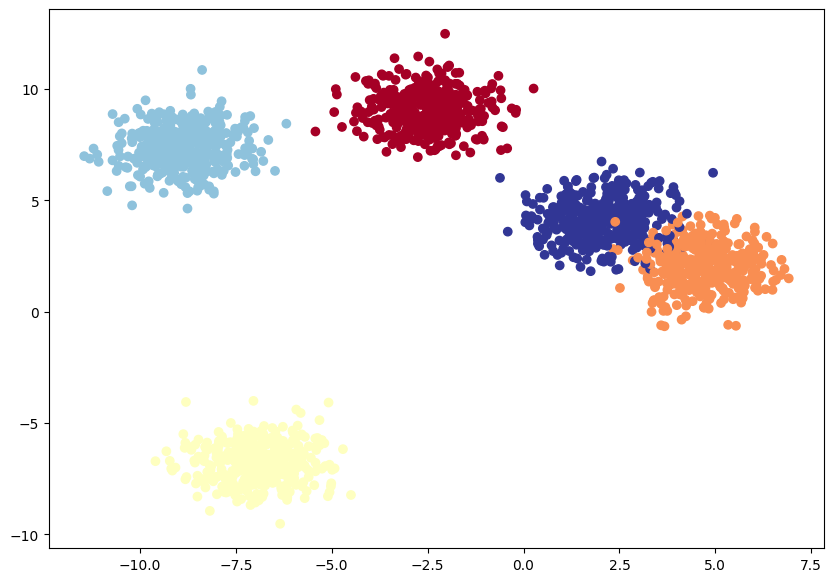

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 5
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X, y = make_blobs(n_samples=2000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=0.9, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)
print(X[:5], y[:5])

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

# Load the Data as the Training and Testing Dataset

In [ ]:
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create data loaders
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


# **Task 1**: Build a Multi-class Classification Model

In [ ]:
import torch
from torch import nn

NUM_FEATURES = 2
NUM_CLASSES = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build model
class ClassificationModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super(ClassificationModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_features, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.7),

            nn.Linear(32, output_features)
        )
        ## Task 1: Complete the model design

    def forward(self, x):
      x = self.model(x)
      return x
        ## Task 1: Complete the model design

# Create a Model and send it to the target device
model = ClassificationModel(input_features=NUM_FEATURES,
                            output_features=NUM_CLASSES,
                            hidden_units=128).to(device)
print(model)

ClassificationModel(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.7, inplace=False)
    (12): Linear(in_features=32, out_features=5, bias=True)
  )
)


# **Task 2 & 3**: Training Loop

In [ ]:
import math
from torch import nn
import torch.optim as optim

# Set number of epochs
epochs = 50

# Set the learning rate
#learning_rate = 0.001


# Set the cost function and optimizer
## Task 2: Define the Cost Function & Optimization Function here
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the Model Save Path
save_path = "/content/classification.pth"

for epoch in range(epochs):
    model.train()
    train_loss = 0
    total_train = 0
    correct_train = 0
    for data, targets in train_loader:
        # move data and targets to the GPU
        data, targets = data.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(data)

        # Task 3: training loop
        y_logits = criterion(outputs, targets)

        train_loss += y_logits.item()

        # Backward pass and optimize
        y_logits.backward()
        optimizer.step()

# Calculate correct predictions
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Print the average losses for this epoch
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')


print("Training complete!")

Epoch [1/50], Train Loss: 1.9312, Train Acc: 21.12%
Epoch [2/50], Train Loss: 1.6957, Train Acc: 29.31%
Epoch [3/50], Train Loss: 1.5498, Train Acc: 37.00%
Epoch [4/50], Train Loss: 1.4232, Train Acc: 41.06%
Epoch [5/50], Train Loss: 1.2987, Train Acc: 50.12%
Epoch [6/50], Train Loss: 1.2086, Train Acc: 55.25%
Epoch [7/50], Train Loss: 1.1496, Train Acc: 60.25%
Epoch [8/50], Train Loss: 1.0979, Train Acc: 63.44%
Epoch [9/50], Train Loss: 1.0683, Train Acc: 66.50%
Epoch [10/50], Train Loss: 1.0154, Train Acc: 68.12%
Epoch [11/50], Train Loss: 0.9762, Train Acc: 71.44%
Epoch [12/50], Train Loss: 0.9676, Train Acc: 72.38%
Epoch [13/50], Train Loss: 0.8949, Train Acc: 78.19%
Epoch [14/50], Train Loss: 0.9211, Train Acc: 76.69%
Epoch [15/50], Train Loss: 0.8880, Train Acc: 79.69%
Epoch [16/50], Train Loss: 0.8734, Train Acc: 79.88%
Epoch [17/50], Train Loss: 0.8621, Train Acc: 81.25%
Epoch [18/50], Train Loss: 0.8568, Train Acc: 81.56%
Epoch [19/50], Train Loss: 0.8421, Train Acc: 82.06%
Ep

# **Task 4**: Evaluation
* Evaluate our model on the testing dataset

Final Test Accuracy: 99.00%


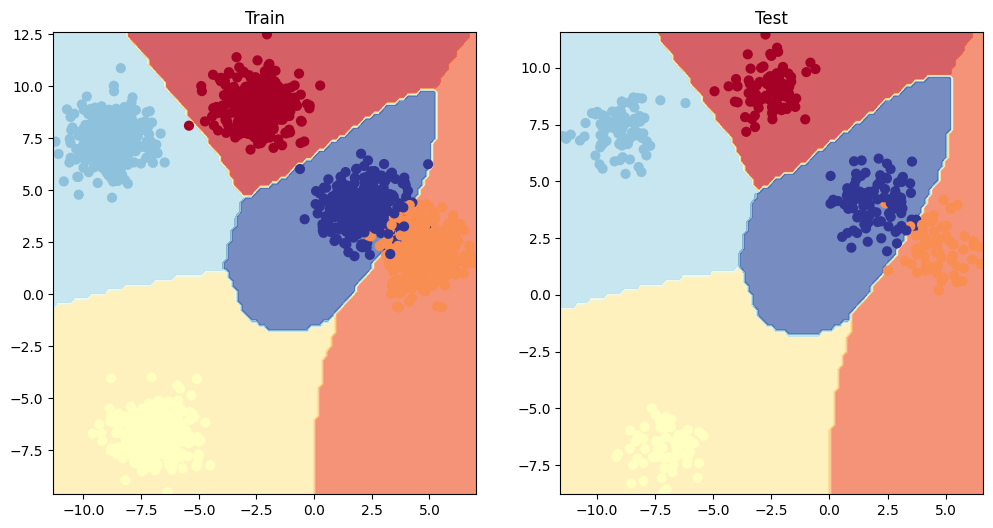

In [ ]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Make predictions
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == batch_y).sum().item()
        total_test += batch_y.size(0)

test_accuracy = 100 * correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# Make Plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train_tensor, y_train_tensor)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test_tensor, y_test_tensor)